<a href="https://colab.research.google.com/github/FrancoPalavicinoG/ML_courses/blob/main/notebooks/Tarea2_Parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 2 - Parte 1: Clasificación utilizando Transformers
##Curso Analítica Textual con Machine Learning

Profesora: Carla Vairetti




## Paso 1: Montar Google Drive
Comenzamos montando Google Drive para acceder al conjunto de datos y guardar cualquier salida.


In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive



## Paso 2: Importar las Bibliotecas Necesarias
A continuación, importamos las bibliotecas necesarias. Estas incluyen:
- `transformers` para cargar y trabajar con modelos transformadores,
- `pandas` y `numpy` para el manejo de datos,
- `torch` para trabajar con PyTorch (la base de nuestros modelos),
- `sklearn` para evaluar el modelo,
- `matplotlib` y `seaborn` para realizar gráficos.


In [32]:
import io
import os
import copy
import torch
import json
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )
from sklearn.utils.class_weight import compute_class_weight
import warnings
from torch.optim import AdamW
from pathlib import Path

tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings("ignore", category=UserWarning)


## Paso 3: Configuración del Modelo
Utilizaremos un modelo BERT preentrenado específico para español (`dccuchile/bert-base-spanish-wwm-cased`) del Hugging Face Model Hub. Este modelo está preentrenado en un gran corpus de texto en español y es adecuado para nuestra tarea de clasificación.


In [3]:
model_path = 'dccuchile/bert-base-spanish-wwm-cased'
model_alias = 'BETO'


## Paso 4: Definir Hiperparámetros
Definimos algunos hiperparámetros esenciales:
- `max_length`: La longitud máxima de la entrada tokenizada.
- `epochs`: Número de épocas de entrenamiento.
- `batch_size`: El tamaño del lote para el entrenamiento.
- `n_labels`: Número de etiquetas en la tarea de clasificación.
- `learning_rate`: La tasa de aprendizaje para el optimizador.


In [4]:
max_length = 512
epochs = 3
batch_size = 8
n_labels = 3
warmup_epochs = 0.2 * epochs
learning_rate = 1e-5


## Paso 5: Cargar el Tokenizador y el Modelo
Cargamos el tokenizador y el modelo utilizando la biblioteca `transformers`. El tokenizador convertirá el texto en tokens que el modelo puede procesar.


In [5]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [6]:
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_path, num_labels=n_labels)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path,
                                                           config=model_config)

model.to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e


## Paso 6: Cargar y Preprocesar los Datos
Cargamos el conjunto de datos desde un archivo Excel. El conjunto de datos contiene reseñas de restaurantes con una calificación correspondiente. Luego, simplificamos las calificaciones en tres categorías: `Negativo`, `Neutral` y `Positivo`.


In [7]:
df = pd.read_pickle('/content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2/df_procesado.pkl')
df

,id,rank,abstract,review,review_tokenizado,abstract_tokenizado,review_texto_final,review_texto_final_len,abstract_texto_final,abstract_texto_final_len
0,1,2,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...,"[bien, comente, propietarios, hora, abandonar,...","[hotel, digno, mencion]","[como, bien, le, comente, a, los, propietarios...",171,"[un, hotel, digno, de, mencion]",5
1,2,2,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ...","[do, dia, familia, reservando, do, habitacione...","[recomendable, lujos, perfecto]","[estuvimos, do, dia, con, mi, familia, reserva...",184,"[recomendable, sin, lujos, pero, todo, perfecto]",6
2,3,1,Decepción,Habíamos escogido este hotel por las buenas op...,"[habiamos, escogido, hotel, buenas, opiniones,...",[decepcion],"[habiamos, escogido, este, hotel, por, la, bue...",138,[decepcion],1
3,4,2,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...,"[vuelto, segunda, vez, estupendo, hotel, grana...","[segunda, vez, inmejorable]","[hemos, vuelto, por, segunda, vez, a, este, es...",104,"[por, segunda, vez, inmejorable]",4
4,5,2,No tan sorpresa,"He estado dos días en Granada por trabajo, soy...","[do, dia, granada, trabajo, autonomo, busco, a...","[tan, sorpresa]","[he, estado, do, dia, en, granada, por, trabaj...",188,"[no, tan, sorpresa]",3
...,...,...,...,...,...,...,...,...,...,...
1811,1812,2,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...,"[empezado, ano, estancia, tres, noches, hotel,...","[remanso, paz, corazon, cordoba]","[hemos, empezado, el, ano, con, una, estancia,...",229,"[remanso, de, paz, en, el, corazon, de, cordoba]",8
1812,1813,2,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...,"[atravesar, umbral, puerta, conduce, zaguan, h...","[oasis, paz, tranquilidad, belleza]","[al, atravesar, el, umbral, de, la, puerta, qu...",480,"[oasis, de, paz, tranquilidad, y, belleza]",6
1813,1814,2,Un lugar para recordar,En este hotel todo son sensaciones y experienc...,"[hotel, sensaciones, experiencias, positivas, ...","[lugar, recordar]","[en, este, hotel, todo, son, sensaciones, y, e...",215,"[un, lugar, para, recordar]",4
1814,1815,2,Extraordinario,Hemos pasado un par de noches en este exquisit...,"[pasado, par, noches, exquisito, hotel, regent...",[extraordinario],"[hemos, pasado, un, par, de, noches, en, este,...",68,[extraordinario],1


In [8]:
df = df[['abstract', 'review', 'rank']]
df

,abstract,review,rank
0,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...,2
1,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ...",2
2,Decepción,Habíamos escogido este hotel por las buenas op...,1
3,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...,2
4,No tan sorpresa,"He estado dos días en Granada por trabajo, soy...",2
...,...,...,...
1811,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...,2
1812,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...,2
1813,Un lugar para recordar,En este hotel todo son sensaciones y experienc...,2
1814,Extraordinario,Hemos pasado un par de noches en este exquisit...,2



## Paso 7: Preparar el Conjunto de Datos
Dividimos los datos en conjuntos de entrenamiento y prueba. También creamos un `Dataset` personalizado de PyTorch para manejar las entradas tokenizadas.


rank
2    1020
0     510
1     285
Name: count, dtype: int64


<Axes: xlabel='rank'>

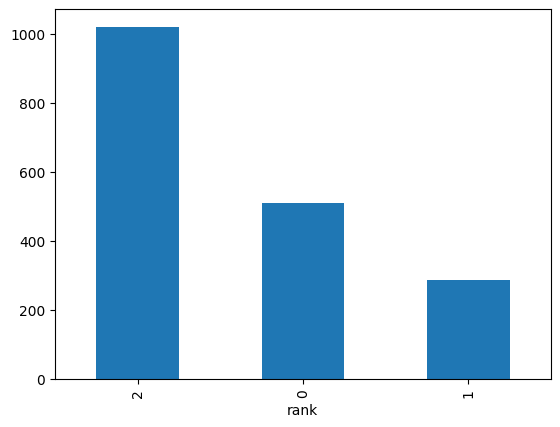

In [9]:
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

Para el entrenamiento de transformers, los tokenizers retornan 3 elemento:

1. **`input_ids`**:
   - Este tensor contiene los IDs de los tokens que representan el texto de entrada. Cada número corresponde a un token específico en el vocabulario del modelo.
   - Los tokens pueden incluir palabras, partes de palabras, o incluso caracteres individuales, dependiendo de cómo se haya tokenizado el texto de entrada.
   - En este ejemplo, el tensor tiene una longitud fija, y los valores `1` al final indican que se ha utilizado un padding para completar la secuencia hasta el tamaño máximo permitido por el modelo.

2. **`token_type_ids`**:
   - Este tensor se utiliza principalmente en modelos como BERT para diferenciar entre dos secuencias diferentes cuando se realizan tareas como preguntas y respuestas o clasificación de pares de oraciones.
   - En este caso, todos los valores son `0`, lo que sugiere que se trata de una sola secuencia de entrada. Si hubiera dos secuencias (como en una tarea de pares de oraciones), se usarían `0` y `1` para distinguirlas.

3. **`attention_mask`**:
   - Este tensor indica al modelo qué tokens debe prestar atención y cuáles debe ignorar (por ejemplo, debido al padding).
   - Los valores `1` indican que el modelo debe prestar atención a esos tokens, mientras que los `0` indican que el modelo debe ignorarlos.
   - En este caso, los primeros valores son `1`, correspondientes a los tokens reales del texto, y los valores al final son `0`, correspondientes a los tokens de padding.

In [10]:
tok_example = tokenizer(df['review'].iloc[0], return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
tok_example

{'input_ids': tensor([[    4,  2144,  1311,  2027,  5609, 30958,  1013,  1065, 12220,  1013,
          1030,  2709,  1008,  9981,  1040,  5225,  1017,  1084, 22340, 30958,
          1049,  1989,  1036, 17274,  1108,  1042,  1861,  1480,  1040,  9762,
         21296, 30933,  1008, 13410,  1009,  1508,  2504,  2440,  1072,  3040,
          1008, 13410,  1084,  1058,  1030,  1627,  1017,  1355,  1110,  3070,
         17182,  1538,  6719,  1147, 19189,  1093,  1008,  1377,  1008,  3165,
          1051,  6054,  1013,  1030,  1403,  5159,  2883,  1135,  1009,  1264,
          2858,  1036,  1030,  6278,  1008,  3661,  1013,  8909, 24408,  1042,
          1456, 10082,  1013,  1030,  1403,  5159,  2883,  1009,  1278,  1030,
          2785,  1062,  1499,  2604, 18173,  1042,  1365,  1062,  2858,  1036,
          1108,  2785,  4488,  1042, 13248,  1009,  1412,  1080,   981,  9794,
          1072,  3040,  1008, 13410,  1038,  1445, 17274,  1022,  1036,  1040,
          5225,  2351,  1114,  1038,  

In [11]:
tokenizer.decode(tok_example['input_ids'][0])

'[CLS] Como bien les comenté a los propietarios a la hora de abandonar el hotel, no dudaré un momento en recomendar una y otra vez el Hotel Albero de Granada. Su situación respecto del centro de Granada no es la mejor, pero para nuestros propósitos era perfecto ( escapada de fin de semana con visita a la Alhambra ). Se encuentra en la carretera de paso a Sierra Nevada y muy cercano a la Alhambra. Por la zona se puede encontrar aparcamiento y este se encuentra en una zona segura y tranquila. Los parkings del centro de Granada que nos recomendaron en el hotel fueron lo que nos dijeron ( nada caros ) y pudimos movernos por el centro perfectamente desde allí. Las habitaciones muy limpias y las camas confortables. El desayuno fue espectacular. Ya teníamos buenas referencias de este maravilloso hotel de una estrella ( que para mí que viajo constantemente son más ) pero ha superado con creces nuestras expectativas. Si vuelvo a Granada no dudaré en hospedarme en el mismo hotel. Muchas gracias 

Ahora podemos utilizar dos secuencias de texto individuales pero tokenizarlas juntas agregando el token serarador ([SEP] en el caso de BETO).

In [12]:
tok_doble_example = tokenizer(df['abstract'].iloc[0], df['review'].iloc[0], return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
tok_doble_example

{'input_ids': tensor([[    4,  1246,  5225, 16901,  1008, 15450,  1127,     5,  2144,  1311,
          2027,  5609, 30958,  1013,  1065, 12220,  1013,  1030,  2709,  1008,
          9981,  1040,  5225,  1017,  1084, 22340, 30958,  1049,  1989,  1036,
         17274,  1108,  1042,  1861,  1480,  1040,  9762, 21296, 30933,  1008,
         13410,  1009,  1508,  2504,  2440,  1072,  3040,  1008, 13410,  1084,
          1058,  1030,  1627,  1017,  1355,  1110,  3070, 17182,  1538,  6719,
          1147, 19189,  1093,  1008,  1377,  1008,  3165,  1051,  6054,  1013,
          1030,  1403,  5159,  2883,  1135,  1009,  1264,  2858,  1036,  1030,
          6278,  1008,  3661,  1013,  8909, 24408,  1042,  1456, 10082,  1013,
          1030,  1403,  5159,  2883,  1009,  1278,  1030,  2785,  1062,  1499,
          2604, 18173,  1042,  1365,  1062,  2858,  1036,  1108,  2785,  4488,
          1042, 13248,  1009,  1412,  1080,   981,  9794,  1072,  3040,  1008,
         13410,  1038,  1445, 17274,  

In [13]:
tokenizer.decode(tok_doble_example['input_ids'][0])

'[CLS] Un hotel digno de mención! [SEP] Como bien les comenté a los propietarios a la hora de abandonar el hotel, no dudaré un momento en recomendar una y otra vez el Hotel Albero de Granada. Su situación respecto del centro de Granada no es la mejor, pero para nuestros propósitos era perfecto ( escapada de fin de semana con visita a la Alhambra ). Se encuentra en la carretera de paso a Sierra Nevada y muy cercano a la Alhambra. Por la zona se puede encontrar aparcamiento y este se encuentra en una zona segura y tranquila. Los parkings del centro de Granada que nos recomendaron en el hotel fueron lo que nos dijeron ( nada caros ) y pudimos movernos por el centro perfectamente desde allí. Las habitaciones muy limpias y las camas confortables. El desayuno fue espectacular. Ya teníamos buenas referencias de este maravilloso hotel de una estrella ( que para mí que viajo constantemente son más ) pero ha superado con creces nuestras expectativas. Si vuelvo a Granada no dudaré en hospedarme e

In [14]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1)

La clase `DatasetFromDataFrame` es una clase personalizada que extiende la funcionalidad de `Dataset` de PyTorch para manejar datos almacenados en un DataFrame de Pandas. Esta clase facilita la preparación de datos para un modelo de aprendizaje profundo.

- **`__init__`**: Guarda el DataFrame que contiene los datos.
- **`__len__`**: Devuelve el número total de ejemplos en el dataset, es decir, el número de filas en el DataFrame.
- **`__getitem__`**: Dado un índice, recupera un ejemplo del dataset. Específicamente, devuelve la etiqueta (rating) y dos textos (el título y el comentario) correspondientes a ese índice.

Ahora inicializamos los datos para el entrenamiento y la validación de un modelo de aprendizaje profundo usando PyTorch:

- **`train_dataset = DatasetFromDataFrame(train_df)`**:
  - Crea un objeto `DatasetFromDataFrame` usando el DataFrame de entrenamiento `train_df`. Este objeto `train_dataset` organizará y permitirá acceder a los datos de entrenamiento en la forma que PyTorch necesita.

- **`train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)`**:
  - Crea un `DataLoader` a partir del dataset de entrenamiento (`train_dataset`). El `DataLoader` es responsable de dividir los datos en lotes (`batch_size`) y de barajarlos aleatoriamente (`shuffle=True`) en cada época de entrenamiento. Esto ayuda a mejorar la eficacia del entrenamiento al mezclar los datos.

- **`valid_dataset =  DatasetFromDataFrame(val_df)`**:
  - Crea un objeto `DatasetFromDataFrame` usando el DataFrame de validación `val_df`. Esto organiza los datos de validación de manera similar a los datos de entrenamiento.

- **`test_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)`**:
  - Crea un `DataLoader` para el dataset de validación (`valid_dataset`). Aquí, los datos no se barajan (`shuffle=False`), ya que el orden no importa tanto para la validación, y queremos mantener consistencia para evaluar el rendimiento del modelo.


## Paso 8: Entrenamiento del los Modelos para los 3 enfoques sexgun `mode`



Un **optimizador** es una herramienta que ajusta los parámetros del modelo para mejorar su rendimiento, buscando minimizar los errores que comete durante el entrenamiento.

Este código crea un **optimizador AdamW**, que es una versión mejorada del optimizador Adam. Su función es ajustar los parámetros del modelo (`model.parameters()`) durante el entrenamiento para reducir los errores. La **tasa de aprendizaje** (`lr = learning_rate`) determina qué tan grandes son los ajustes en cada paso. AdamW es especialmente útil porque maneja bien grandes conjuntos de datos y evita que los parámetros se desajusten demasiado.

Este código sigue un flujo típico de entrenamiento y evaluación, donde el modelo aprende de los datos de entrenamiento y luego se evalúa en datos de validación para asegurarse de que está mejorando, eligiendo la mejor epoca segun la metrica Accuracy en el la evaluación:

1. **Variables Iniciales**:
   - `best_epoch` y `best_accuracy` se inicializan en 0 para rastrear la mejor época y la mejor precisión alcanzada durante el entrenamiento.

2. **Training Loop (`for epoch in tqdm(range(epochs))`)**:
   - **Entrenamiento**:
     - **Preparación**: Se inician listas para las etiquetas verdaderas y predichas (`epoch_true_labels`, `epoch_predicted_labels`) y un contador de pérdida (`total_loss`).
     - **Bucle sobre los datos de entrenamiento**: Por cada lote en `train_dataloader`, se obtienen las etiquetas y los textos, que se tokenizan y envían al modelo.
     - **Actualización del Modelo**: Se calcula la pérdida, se realiza la retropropagación (`loss.backward()`), y se actualizan los parámetros del modelo con el optimizador (`optimizer.step()`).
     - **Monitoreo**: Se acumulan las pérdidas y se calculan las etiquetas predichas, actualizando el progreso en la barra de tareas.

   - **Evaluación**:
     - Similar al entrenamiento, pero sin actualizar los parámetros del modelo (`model.eval()` desactiva el modo de entrenamiento). Se calculan las pérdidas y las etiquetas predichas para los datos de validación.
     - **Comparación de Precisión**: Después de evaluar, se calcula la precisión. Si esta supera la mejor precisión registrada (`best_accuracy`), se actualizan `best_epoch` y `best_accuracy`.
     - **Matriz de Confusión**: Se genera y muestra una matriz de confusión para visualizar el rendimiento del modelo en clasificar las etiquetas.



In [15]:
def train_and_evaluate(mode, model_path):

    assert mode in ["text_review", "text_abstract", "text_both"], "Modo inválido"

    model_config = AutoConfig.from_pretrained(model_path, num_labels=n_labels)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, config=model_config)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    model.to(device)

    class DatasetFromDataFrame(Dataset):
        def __init__(self, dataframe):
            self.data = dataframe

        def __len__(self):
            return len(self.data)

        def __getitem__(self, index):
            label = int(self.data.iloc[index]['rank'])
            text_1 = str(self.data.iloc[index]['abstract'])
            text_2 = str(self.data.iloc[index]['review'])
            return label, text_1, text_2

    # Dataset & Dataloaders
    train_dataset = DatasetFromDataFrame(train_df)
    valid_dataset =  DatasetFromDataFrame(val_df)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Initialization
    best_epoch = 0
    best_accuracy = 0

    for epoch in tqdm(range(epochs)):
        # TRAINING
        epoch_true_labels = []
        epoch_predicted_labels = []
        total_loss = 0

        t_bar = tqdm(train_dataloader)
        model.train()

        for step_counter, (labels, text_1, text_2) in enumerate(t_bar):
            labels = labels.to(device)

            # Input selection according the mode (approach)
            if mode == "text_review":
                inputs = tokenizer(text_2, return_tensors='pt', padding='max_length',
                                   truncation=True, max_length=max_length)
            elif mode == "text_abstract":
                inputs = tokenizer(text_1, return_tensors='pt', padding='max_length',
                                   truncation=True, max_length=max_length)
            elif mode == "text_both":
                inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length',
                                   truncation=True, max_length=max_length)

            inputs['labels'] = labels
            inputs = {k: v.type(torch.long).to(device) for k, v in inputs.items()}

            model.zero_grad()
            optimizer.zero_grad()

            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()
            epoch_true_labels.extend(labels.cpu().tolist())
            epoch_predicted_labels.extend(predicted_labels)

            epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
            t_bar.set_description(f'Training... EPOCH {epoch+1} Step Loss {total_loss/(step_counter+1):.4f}, Epoch Accuracy {epoch_report["accuracy"]:.4f}')
            t_bar.refresh()

        # --- EVALUATION ---
        epoch_true_labels = []
        epoch_predicted_labels = []
        total_loss = 0

        v_bar = tqdm(test_dataloader)
        model.eval()

        for step_counter, (labels, text_1, text_2) in enumerate(v_bar):
            labels = labels.to(device)

            if mode == "text_review":
                inputs = tokenizer(text_2, return_tensors='pt', padding='max_length',
                                   truncation=True, max_length=max_length)
            elif mode == "text_abstract":
                inputs = tokenizer(text_1, return_tensors='pt', padding='max_length',
                                   truncation=True, max_length=max_length)
            elif mode == "text_both":
                inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length',
                                   truncation=True, max_length=max_length)

            inputs['labels'] = labels
            inputs = {k: v.type(torch.long).to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                loss = outputs.loss

            total_loss += loss.item()
            predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

            epoch_true_labels.extend(labels.cpu().tolist())
            epoch_predicted_labels.extend(predicted_labels)

            epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
            v_bar.set_description(f'Validation... EPOCH {epoch+1} Avg Loss {total_loss/(step_counter+1):.4f}, Avg Accuracy {epoch_report["accuracy"]:.4f}')
            v_bar.refresh()

        evaluations_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        print(classification_report(epoch_true_labels, epoch_predicted_labels))
        epoch_accuracy = evaluations_report['accuracy']

        if epoch_accuracy > best_accuracy:
            best_epoch = epoch + 1
            best_accuracy = epoch_accuracy
            best_report = evaluations_report
            print(f'*** Best Epoch: {best_epoch}, Best Accuracy: {best_accuracy:.4f} ***')

        # --- Confusion Matrix ---
        conf_matrix = confusion_matrix(epoch_true_labels, epoch_predicted_labels)
        fig, ax = plt.subplots()
        plt.title(f'Confusion Matrix for {mode}')
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Negativo', 'Neutro', 'Positivo'],
                    yticklabels=['Negativo', 'Neutro', 'Positivo'])
        plt.show()

    # RESULTS
    results_df = pd.DataFrame(best_report).T
    results_df['model'] = f'BETO - {mode}'
    results_df = results_df.drop(columns=['support'])
    results_df = results_df.reset_index()
    results_df.rename(columns={'index': 'class'}, inplace=True)

    return results_df

### Enfoque only `review`

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.82      0.94      0.88        94
           1       0.50      0.05      0.10        57
           2       0.84      0.99      0.91       212

    accuracy                           0.83       363
   macro avg       0.72      0.66      0.63       363
weighted avg       0.78      0.83      0.77       363

*** Best Epoch: 1, Best Accuracy: 0.8292 ***


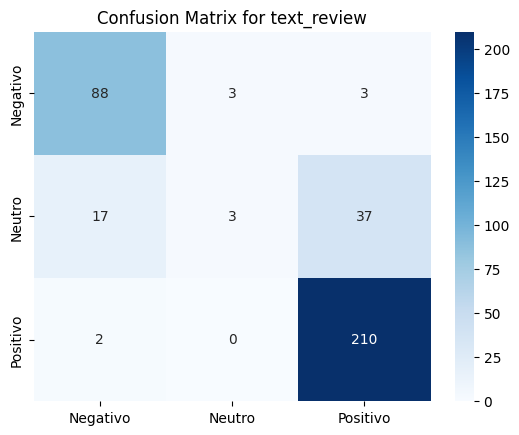

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        94
           1       0.52      0.21      0.30        57
           2       0.86      0.97      0.91       212

    accuracy                           0.83       363
   macro avg       0.74      0.70      0.70       363
weighted avg       0.80      0.83      0.81       363

*** Best Epoch: 2, Best Accuracy: 0.8347 ***


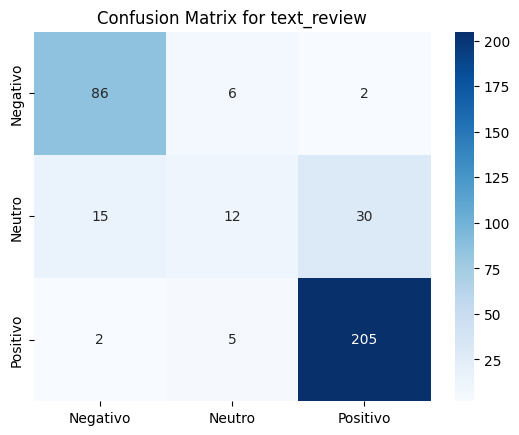

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.70      0.80        94
           1       0.43      0.68      0.53        57
           2       0.93      0.89      0.91       212

    accuracy                           0.81       363
   macro avg       0.77      0.76      0.75       363
weighted avg       0.85      0.81      0.82       363



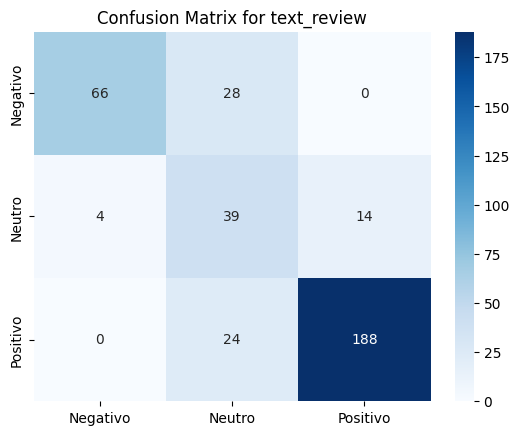

In [16]:
beto_review = train_and_evaluate("text_review", model_path)

### Enfoque only `abstract`

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.70      0.71      0.71        94
           1       1.00      0.02      0.03        57
           2       0.74      0.93      0.83       212

    accuracy                           0.73       363
   macro avg       0.81      0.55      0.52       363
weighted avg       0.77      0.73      0.67       363

*** Best Epoch: 1, Best Accuracy: 0.7328 ***


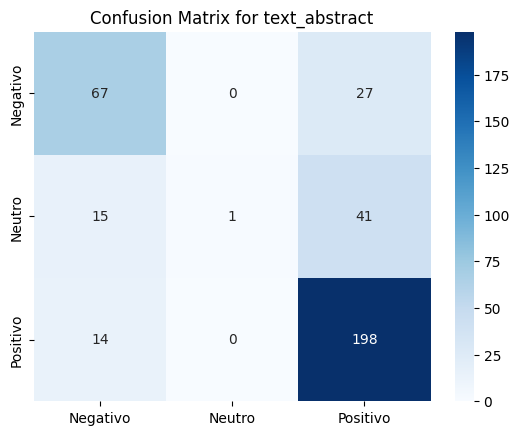

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.66      0.91      0.76        94
           1       0.47      0.12      0.19        57
           2       0.86      0.88      0.87       212

    accuracy                           0.77       363
   macro avg       0.66      0.64      0.61       363
weighted avg       0.74      0.77      0.73       363

*** Best Epoch: 2, Best Accuracy: 0.7686 ***


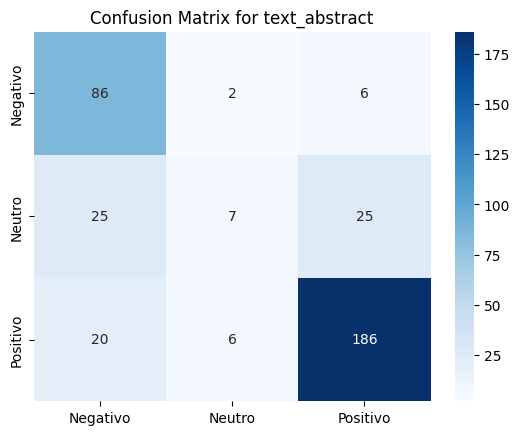

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.75      0.80      0.77        94
           1       0.49      0.35      0.41        57
           2       0.85      0.89      0.87       212

    accuracy                           0.78       363
   macro avg       0.70      0.68      0.68       363
weighted avg       0.77      0.78      0.77       363

*** Best Epoch: 3, Best Accuracy: 0.7824 ***


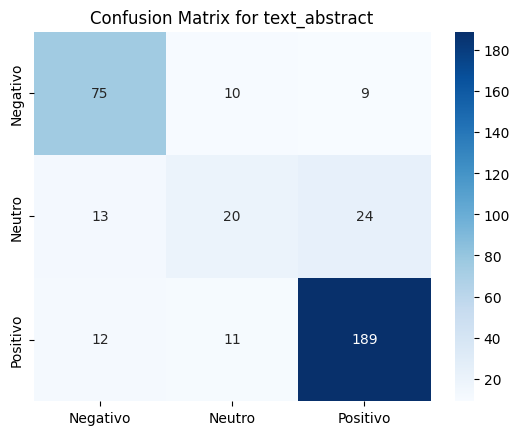

In [17]:
beto_abstract = train_and_evaluate("text_abstract", model_path)

### Enfoque fusion de ambos `abstract`+`review`

En el siguiente experimento, veremos si es posible mejorar la detección de polaridad al incorporar información del título en el texto de entrada.

Podemos correr el mismo loop de entrenamiento pero ahora utilizando el comentario y el titulo como entrada. Pero primero se debe inicializar el modelo desde 0, sino estarias entrenando el mismo modelo.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.84      0.94      0.88        94
           1       0.53      0.49      0.51        57
           2       0.93      0.90      0.92       212

    accuracy                           0.85       363
   macro avg       0.77      0.78      0.77       363
weighted avg       0.84      0.85      0.84       363

*** Best Epoch: 1, Best Accuracy: 0.8457 ***


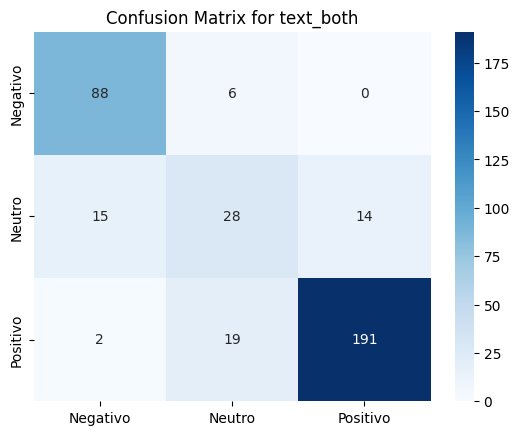

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.86      0.96      0.90        94
           1       0.58      0.39      0.46        57
           2       0.90      0.93      0.92       212

    accuracy                           0.85       363
   macro avg       0.78      0.76      0.76       363
weighted avg       0.84      0.85      0.84       363

*** Best Epoch: 2, Best Accuracy: 0.8540 ***


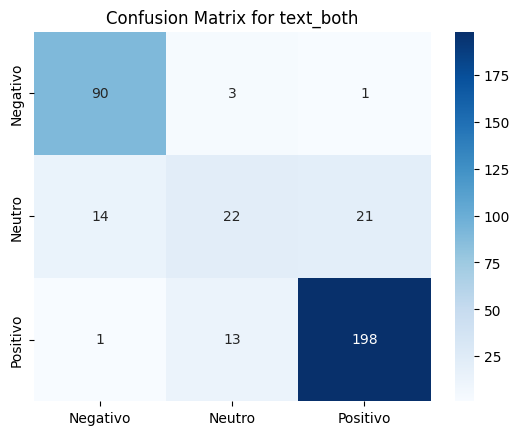

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.86      0.90        94
           1       0.53      0.61      0.57        57
           2       0.92      0.91      0.91       212

    accuracy                           0.85       363
   macro avg       0.79      0.80      0.79       363
weighted avg       0.86      0.85      0.86       363



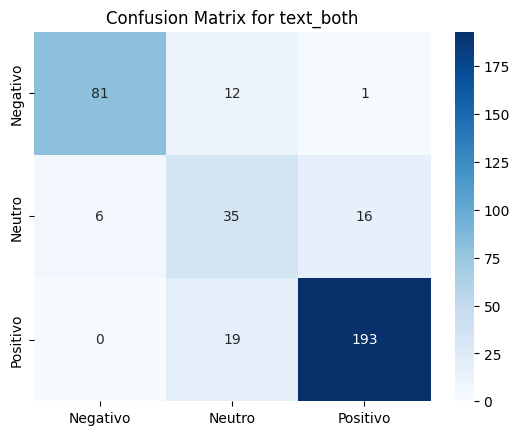

In [18]:
beto_both = train_and_evaluate("text_both", model_path)

## Paso 9: Resultados Experimentos

Resultados BETO de los 3 enfoques: `abstract`, `reviews` y  `abstract`+`reviews`

In [19]:
beto_results_df = pd.concat([beto_review, beto_abstract, beto_both])
beto_results_df

,class,precision,recall,f1-score,model
0,0,0.834951,0.914894,0.873096,BETO - text_review
1,1,0.521739,0.210526,0.300000,BETO - text_review
2,2,0.864979,0.966981,0.913140,BETO - text_review
3,accuracy,0.834711,0.834711,0.834711,BETO - text_review
4,macro avg,0.740556,0.697467,0.695412,BETO - text_review
5,weighted avg,0.803306,0.834711,0.806493,BETO - text_review
0,0,0.750000,0.797872,0.773196,BETO - text_abstract
1,1,0.487805,0.350877,0.408163,BETO - text_abstract
2,2,0.851351,0.891509,0.870968,BETO - text_abstract
3,accuracy,0.782369,0.782369,0.782369,BETO - text_abstract


Cargamos los resultados del Laboratorio 2

In [20]:
tf_idf_results_df = pd.read_pickle('/content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2/tf_idf_results.pkl')
tf_idf_results_df

,class,precision,recall,f1-score,model,lema state
0,0.0,0.126582,0.089286,0.104712,Naive Bayes,Lemma
1,1.0,0.245902,0.092025,0.133929,Naive Bayes,Lemma
2,2.0,0.736903,0.874309,0.799747,Naive Bayes,Lemma
3,accuracy,0.658659,0.658659,0.658659,Naive Bayes,Lemma
4,macro avg,0.369796,0.351873,0.346129,Naive Bayes,Lemma
...,...,...,...,...,...,...
67,1.0,0.164502,0.233129,0.192893,Neural Network,Not Lemma
68,2.0,0.729430,0.636740,0.679941,Neural Network,Not Lemma
69,accuracy,0.517518,0.517518,0.517518,Neural Network,Not Lemma
70,macro avg,0.342095,0.343528,0.339332,Neural Network,Not Lemma


Creamos la tabla de comparacion de los modelos entrenados en el Laboratorio 2 y BETO solo comentarios

In [21]:
results_df = pd.concat([tf_idf_results_df, beto_results_df])
results_df.reset_index(inplace=True)
results_df = results_df.drop(columns = ['index'])
results_df

,class,precision,recall,f1-score,model,lema state
0,0.0,0.126582,0.089286,0.104712,Naive Bayes,Lemma
1,1.0,0.245902,0.092025,0.133929,Naive Bayes,Lemma
2,2.0,0.736903,0.874309,0.799747,Naive Bayes,Lemma
3,accuracy,0.658659,0.658659,0.658659,Naive Bayes,Lemma
4,macro avg,0.369796,0.351873,0.346129,Naive Bayes,Lemma
...,...,...,...,...,...,...
85,1,0.578947,0.385965,0.463158,BETO - text_both,NaN
86,2,0.900000,0.933962,0.916667,BETO - text_both,NaN
87,accuracy,0.853994,0.853994,0.853994,BETO - text_both,NaN
88,macro avg,0.778697,0.759125,0.761449,BETO - text_both,NaN


Tal como lo hicimos en el Laboratorio 2, podemos filtrar este DataFrame de resultados, para solo ver las metricas Weighted-Average y ordernar segun una de las metricas, por ejemplo F1-Score

In [22]:
results_df.loc[results_df['class'] == 'weighted avg'].sort_values(by=['f1-score'])

,class,precision,recall,f1-score,model,lema state
29,weighted avg,0.585989,0.304304,0.348106,Decision Tree,Lemma
65,weighted avg,0.570471,0.336336,0.385344,Decision Tree,Not Lemma
59,weighted avg,0.572784,0.478478,0.510799,Random Forest,Not Lemma
23,weighted avg,0.563058,0.485485,0.517033,Random Forest,Lemma
35,weighted avg,0.571330,0.493493,0.525544,Neural Network,Lemma
71,weighted avg,0.570315,0.517518,0.540517,Neural Network,Not Lemma
17,weighted avg,0.561183,0.685686,0.600608,SVM,Lemma
47,weighted avg,0.568381,0.669670,0.604328,Logistic Regression,Not Lemma
53,weighted avg,0.549430,0.697698,0.609172,SVM,Not Lemma
11,weighted avg,0.581977,0.660661,0.610697,Logistic Regression,Lemma


Considerando F1 weighted como métrica, podemos observar que la ganancia de utilizar BERT (BETO) es notable, pasando de un 0.618 (mejor modelo tradicional, Naive Bayes sin lematización) a un 0.832. Se concluye sobre la importancia de considerar (1) una estrategia capaz de modelar los datos como secuencias de palabras (tensor) en vez de palabras independientes (TF-IDF), y (2) las virtudes de un modelo pre-entrenado con grandes volúmenes de texto en castellano.

Considerando F1 weighted como métrica, podemos observar que la ganancia de utilizar BERT (BETO) con el título además del comentario logra una ganancia pequeña pero relevante, pasando de un 0.831 a un 0.849. Se concluye que hay valor en combinar el título y el cuerpo comentario, aunque la principal capacidad predictiva se cuenta con este último.

## Paso 10: Visualización de los resultados

✅ Ranking guardado en: /content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2/ranking_modelos_macro_avg.csv


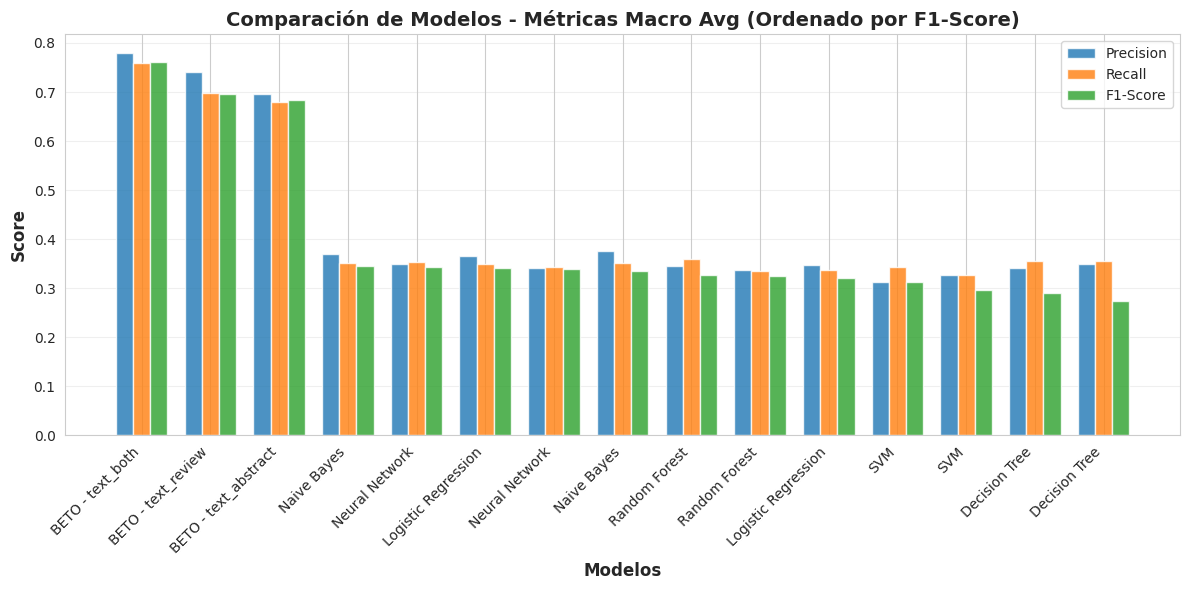

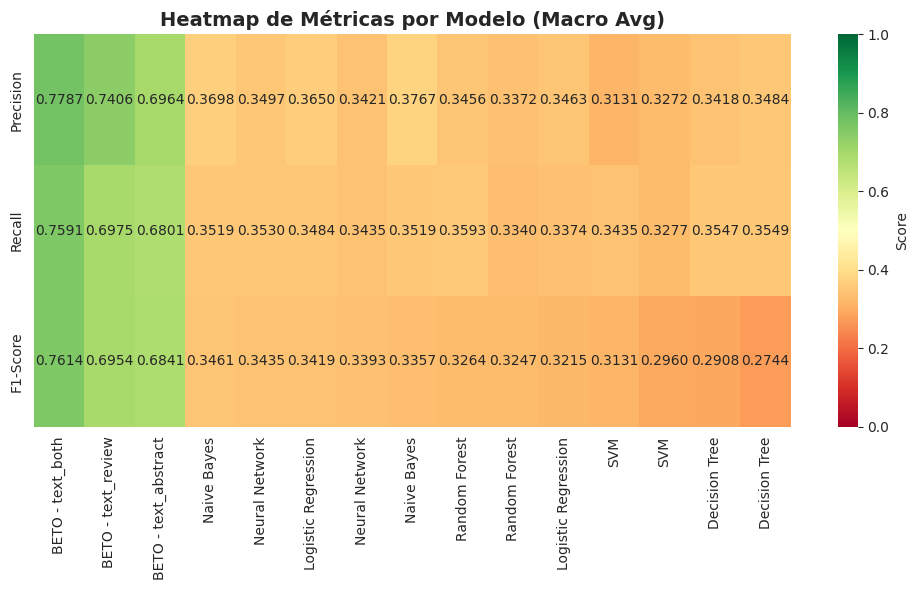


=== TABLA COMPLETA ORDENADA POR F1-SCORE ===
✅ Tabla completa guardada en: /content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2/resultados_completos_ordenados.csv


In [36]:
# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# ORDENAR POR F1-SCORE (Macro Avg)
macro_avg_df = results_df[results_df['class'] == 'macro avg'].copy()
macro_avg_df = macro_avg_df.sort_values('f1-score', ascending=False)

# GUARDAR RANKING DE MODELOS (Macro Avg)
out_dir = Path("/content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2")
out_dir.mkdir(parents=True, exist_ok=True)

ranking_file = os.path.join(out_dir, 'ranking_modelos_macro_avg.csv')
macro_avg_df_export = macro_avg_df[['model', 'precision', 'recall', 'f1-score']].copy()
macro_avg_df_export.to_csv(ranking_file, index=False, encoding='utf-8')
print(f"✅ Ranking guardado en: {ranking_file}")

# GRÁFICO DE BARRAS AGRUPADAS
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = np.arange(len(macro_avg_df))
width = 0.25

ax.bar(x - width, macro_avg_df['precision'], width, label='Precision', alpha=0.8)
ax.bar(x, macro_avg_df['recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, macro_avg_df['f1-score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Modelos', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Modelos - Métricas Macro Avg (Ordenado por F1-Score)',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(macro_avg_df['model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# HEATMAP DE TODAS LAS MÉTRICAS
fig, ax = plt.subplots(figsize=(10, 6))
heatmap_data = macro_avg_df[['precision', 'recall', 'f1-score']].T
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn',
            xticklabels=macro_avg_df['model'],
            yticklabels=['Precision', 'Recall', 'F1-Score'],
            cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
ax.set_title('Heatmap de Métricas por Modelo (Macro Avg)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# TABLA ORDENADA FINAL
print("\n=== TABLA COMPLETA ORDENADA POR F1-SCORE ===")
results_sorted = results_df.copy()

results_sorted['sort_key'] = results_sorted.apply(
    lambda row: macro_avg_df[macro_avg_df['model'] == row['model']]['f1-score'].values[0]
    if row['model'] in macro_avg_df['model'].values else 0,
    axis=1
)
results_sorted = results_sorted.sort_values(['sort_key', 'class'], ascending=[False, True])
results_sorted = results_sorted.drop(columns=['sort_key'])

# GUARDAR TABLA COMPLETA ORDENADA
tabla_completa_file = os.path.join(out_dir, 'resultados_completos_ordenados.csv')
results_sorted_export = results_sorted.copy()
results_sorted_export.to_csv(tabla_completa_file, index=False, encoding='utf-8')
print(f"✅ Tabla completa guardada en: {tabla_completa_file}")

### Guardemos el modelo

In [37]:
base_path = "/content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2/"

model.save_pretrained(f"{base_path}/BETO_review")
tokenizer.save_pretrained(f"{base_path}/BETO_review")

model.save_pretrained(f"{base_path}/BETO_abstract")
tokenizer.save_pretrained(f"{base_path}/BETO_abstract")

model.save_pretrained(f"{base_path}/BETO_both")
tokenizer.save_pretrained(f"{base_path}/BETO_both")

('/content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2//BETO_both/tokenizer_config.json',
 '/content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2//BETO_both/special_tokens_map.json',
 '/content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2//BETO_both/vocab.txt',
 '/content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2//BETO_both/added_tokens.json',
 '/content/drive/MyDrive/202520/ANALITICA TEXTUAL/T2//BETO_both/tokenizer.json')